# DenseNet169


In [1]:
# Upgrade and install dependencies
!pip install --upgrade pip
!pip install pandas
!pip install sklearn
!pip install seaborn

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix

In [3]:
# Set memory growth and list GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU name: ", tf.test.gpu_device_name())

TensorFlow version:  2.8.0
Num GPUs Available:  1
GPU name:  /device:GPU:0


# Preparation of the data set


In [4]:
# Set image_dataset_from_directory parameters
DIRECTORY = "datasets/Split_0-Binary"
LABELS = "inferred"
LABEL_MODE = "int"
COLOR_MODE = "rgb"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SHUFFLE = True
SEED = 1777
VALIDATION_SPLIT = 0.2
CROP_TO_ASPECT_RATIO = True

# Create training set
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory = DIRECTORY,
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,
    validation_split = VALIDATION_SPLIT, 
    subset = "training",    
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)
# Create validation set
val_ds = keras.preprocessing.image_dataset_from_directory(
    directory = DIRECTORY,
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,
    validation_split = VALIDATION_SPLIT, 
    subset = "validation",    
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)

Found 23061 files belonging to 2 classes.
Using 18449 files for training.
Found 23061 files belonging to 2 classes.
Using 4612 files for validation.


In [5]:
# Create test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    directory = "datasets/Split_1-Binary",
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,   
    validation_split = None, 
    subset = None,   
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)

Found 24092 files belonging to 2 classes.


In [6]:
# Optimizing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Explore dataset

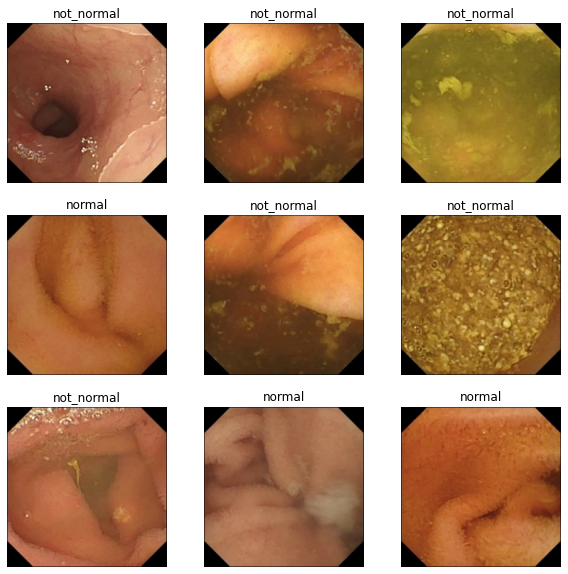

In [7]:
class_names = ["normal", "not_normal"]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
def plot_cm(cf_matrix):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# Creating and training the model

In [9]:
# Import base model and freeze layers
base_model = tf.keras.applications.densenet.DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False

51888128/51877672 [==============================] - 3s 0us/step


In [10]:
# Print model summary
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 pool4_pool (AveragePooling2D)  (None, 7, 7, 640)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['pool4_pool[0][0]']             
 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 7, 7, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block5_0_relu[0][0]']    
                                                                                                  
 conv5_block5_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block5_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block9_1_relu[0][0]']    
                                                                                                  
 conv5_block9_concat (Concatena  (None, 7, 7, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 7, 7, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block14_0_bn (BatchNorma  (None, 7, 7, 1056)  4224        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_0_relu (Activati  (None, 7, 7, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 7, 7, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block18_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block18_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block18_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 7, 7, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)     

 conv5_block22_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block22_1_relu[0][0]']   
                                                                                                  
 conv5_block22_concat (Concaten  (None, 7, 7, 1344)  0           ['conv5_block21_concat[0][0]',   
 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 7, 7, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 7, 7, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block27_0_relu (Activati  (None, 7, 7, 1472)  0           ['conv5_block27_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 7, 7, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block31_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 7, 7, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_blo

In [11]:
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
# Getting output tensor of the last layer that we want to include
x = layer_dict['relu'].output

In [12]:
# Add custom layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x) 
predictions = Dense(1, activation = None)(x)
model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

In [13]:
# Print custom model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 pool4_pool (AveragePooling2D)  (None, 7, 7, 640)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['pool4_pool[0][0]']             
 ization)                                                                                         
                                                                                                  
 conv5_block1_0_relu (Activatio  (None, 7, 7, 640)   0           ['conv5_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block5_0_relu[0][0]']    
                                                                                                  
 conv5_block5_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block5_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block9_1_relu[0][0]']    
                                                                                                  
 conv5_block9_concat (Concatena  (None, 7, 7, 928)   0           ['conv5_block8_concat[0][0]',    
 te)                                                              'conv5_block9_2_conv[0][0]']    
                                                                                                  
 conv5_block10_0_bn (BatchNorma  (None, 7, 7, 928)   3712        ['conv5_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block14_0_bn (BatchNorma  (None, 7, 7, 1056)  4224        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block14_0_relu (Activati  (None, 7, 7, 1056)  0           ['conv5_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block14_1_conv (Conv2D)  (None, 7, 7, 128)    135168      ['conv5_block14_0_relu[0][0]']   
                                                                                                  
 conv5_block14_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block14_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block18_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block18_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block18_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block18_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block18_1_relu[0][0]']   
                                                                                                  
 conv5_block18_concat (Concaten  (None, 7, 7, 1216)  0           ['conv5_block17_concat[0][0]',   
 ate)     

 conv5_block22_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block22_1_relu[0][0]']   
                                                                                                  
 conv5_block22_concat (Concaten  (None, 7, 7, 1344)  0           ['conv5_block21_concat[0][0]',   
 ate)                                                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, 7, 7, 1344)  5376        ['conv5_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block23_0_relu (Activati  (None, 7, 7, 1344)  0           ['conv5_block23_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block27_0_relu (Activati  (None, 7, 7, 1472)  0           ['conv5_block27_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block27_1_conv (Conv2D)  (None, 7, 7, 128)    188416      ['conv5_block27_0_relu[0][0]']   
                                                                                                  
 conv5_block27_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block27_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block27_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block31_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block31_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block31_1_relu[0][0]']   
                                                                                                  
 conv5_block31_concat (Concaten  (None, 7, 7, 1632)  0           ['conv5_block30_concat[0][0]',   
 ate)                                                             'conv5_block31_2_conv[0][0]']   
                                                                                                  
 conv5_blo

In [14]:
# Confirm which layers that are trainable
for l in model.layers:
    print(l.name, l.trainable)

input_1 False
zero_padding2d False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_conc

conv5_block3_2_conv False
conv5_block3_concat False
conv5_block4_0_bn False
conv5_block4_0_relu False
conv5_block4_1_conv False
conv5_block4_1_bn False
conv5_block4_1_relu False
conv5_block4_2_conv False
conv5_block4_concat False
conv5_block5_0_bn False
conv5_block5_0_relu False
conv5_block5_1_conv False
conv5_block5_1_bn False
conv5_block5_1_relu False
conv5_block5_2_conv False
conv5_block5_concat False
conv5_block6_0_bn False
conv5_block6_0_relu False
conv5_block6_1_conv False
conv5_block6_1_bn False
conv5_block6_1_relu False
conv5_block6_2_conv False
conv5_block6_concat False
conv5_block7_0_bn False
conv5_block7_0_relu False
conv5_block7_1_conv False
conv5_block7_1_bn False
conv5_block7_1_relu False
conv5_block7_2_conv False
conv5_block7_concat False
conv5_block8_0_bn False
conv5_block8_0_relu False
conv5_block8_1_conv False
conv5_block8_1_bn False
conv5_block8_1_relu False
conv5_block8_2_conv False
conv5_block8_concat False
conv5_block9_0_bn False
conv5_block9_0_relu False
conv5_bl

In [15]:
# Compile model
adamax = Adamax(learning_rate = 1e-04)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=adamax,
metrics=["binary_accuracy"])

In [16]:
# Train model
history = model.fit(
    train_ds, 
    epochs=100, 
    batch_size=32, 
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
    ]
)

Epoch 1/100
577/577 [==============================] - 93s 146ms/step - loss: 0.7105 - binary_accuracy: 0.8623 - val_loss: 0.1998 - val_binary_accuracy: 0.9248
Epoch 2/100
577/577 [==============================] - 78s 135ms/step - loss: 0.1857 - binary_accuracy: 0.9278 - val_loss: 0.1716 - val_binary_accuracy: 0.9430
Epoch 3/100
577/577 [==============================] - 78s 134ms/step - loss: 0.1564 - binary_accuracy: 0.9391 - val_loss: 0.1635 - val_binary_accuracy: 0.9510
Epoch 4/100
577/577 [==============================] - 77s 134ms/step - loss: 0.1249 - binary_accuracy: 0.9513 - val_loss: 0.1179 - val_binary_accuracy: 0.9579
Epoch 5/100
577/577 [==============================] - 77s 134ms/step - loss: 0.1066 - binary_accuracy: 0.9585 - val_loss: 0.1190 - val_binary_accuracy: 0.9493
Epoch 6/100
577/577 [==============================] - 77s 134ms/step - loss: 0.0875 - binary_accuracy: 0.9666 - val_loss: 0.1405 - val_binary_accuracy: 0.9425
Epoch 7/100
577/577 [===================

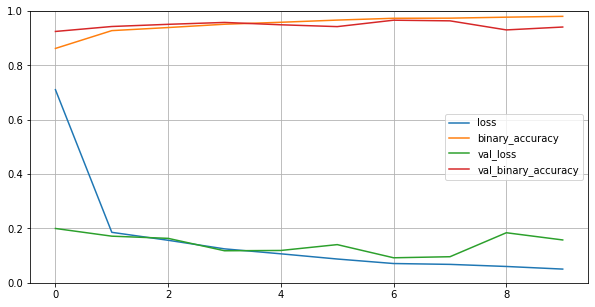

In [17]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [18]:
# Evaluate the trained model
model.evaluate(test_ds)

753/753 [==============================] - 78s 104ms/step - loss: 0.7093 - binary_accuracy: 0.7985


[0.7092891931533813, 0.7984808087348938]

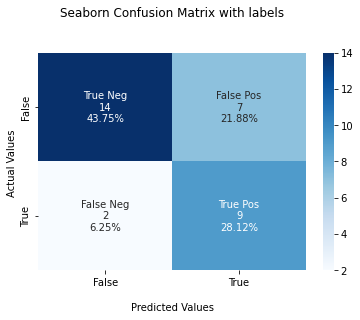

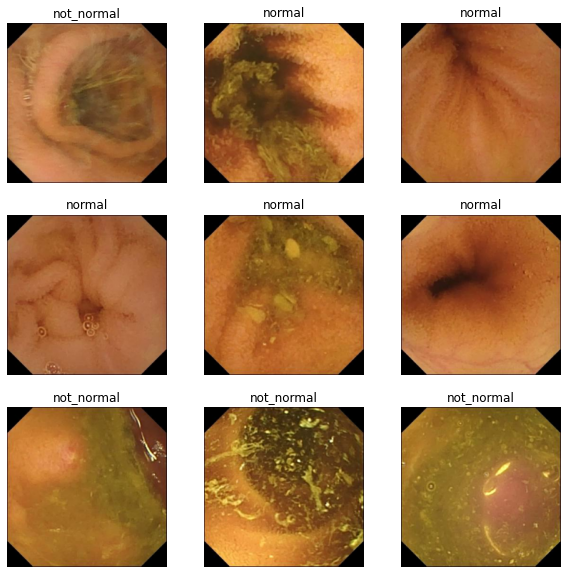

In [19]:
# Plot predictions
test_batches = tf.data.experimental.cardinality(test_ds)
test_dataset = test_ds.take(test_batches // 5)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

cm = confusion_matrix(label_batch, predictions.numpy())

plot_cm(cm)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")